In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras.callbacks import Callback
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Reshape, Conv2DTranspose, LSTM
from sklearn.model_selection import train_test_split
import cv2
import random
import datetime

In [ ]:
def generate_movies(n_samples=100,n_frames=24):
    row = 64
    col = 64
    movies = np.zeros((n_samples, n_frames, row, col, 1), dtype='float')

    for i in range(n_samples):
        n = np.random.randint(3, 5)

        for j in range(n):
            xstart = np.random.randint(24, 40)
            ystart = np.random.randint(24, 40)
            directionx = np.random.randint(0, 3) - 1
            directiony = np.random.randint(0, 3) - 1
            w = np.random.randint(3, 6)

            for t in range(n_frames):
                x_shift = xstart + directionx * t
                y_shift = ystart + directiony * t
                movies[i, t, x_shift - w : x_shift + w, y_shift - w : y_shift + w, 0] += 1

                if np.random.randint(0, 2):
                    noise_f = (-1) ** np.random.randint(0, 2)
                    movies[i,t,x_shift - w - 1 : x_shift + w + 1,y_shift - w - 1 : y_shift + w + 1,0] += (noise_f * 0.1)
                
    movies[movies >= 1] = 1
    return movies
  


In [ ]:
def expandDim(image):
  return cv2.resize(image, (250,250))
def threshold(image):
  return np.array([0.0 if px < 0.5 else 1.0 for row in image for px in row]).reshape(*image.shape)

In [ ]:
movies = generate_movies()
# Creating sequences of 7 for input and corresponding single for output
input_sequence = np.array([np.array([movie[i:i+7] for i in range(movies.shape[1]-7)]) for movie in movies])
output_sequence = np.array([np.array([movie[i+7] for i in range(movies.shape[1]-7)]) for movie in movies])
print(f'input_seq_shape: {input_sequence.shape}, output_seq_shape: {output_sequence.shape}')


# Merge all sequences 
input_sequence_merged = np.array([frame for movie in input_sequence for frame in movie])
output_sequence_merged = np.array([frame for movie in output_sequence for frame in movie])
del input_sequence
del output_sequence
print(f'input sequence shape: {input_sequence_merged.shape}')
print(f'output sequence shape: {output_sequence_merged.shape}')

x_train, x_test, y_train, y_test = train_test_split(input_sequence_merged, output_sequence_merged, test_size=0.1)
print(f'train+valid input set shape: {x_train.shape}')
print(f'train+valid output set shape: {y_train.shape}')
print(f'test input set shape: {x_test.shape}')
print(f'test output set shape: {y_test.shape}')

input_seq_shape: (100, 17, 7, 64, 64, 1), output_seq_shape: (100, 17, 64, 64, 1)
input sequence shape: (1700, 7, 64, 64, 1)
output sequence shape: (1700, 64, 64, 1)
train+valid input set shape: (1530, 7, 64, 64, 1)
train+valid output set shape: (1530, 64, 64, 1)
test input set shape: (170, 7, 64, 64, 1)
test output set shape: (170, 64, 64, 1)


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 8.5MB/s 



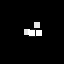

In [ ]:
import imageio
from tensorflow_docs.vis import embed

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=8)
  return embed.embed_file('./animation.gif')

to_gif(movies[9])

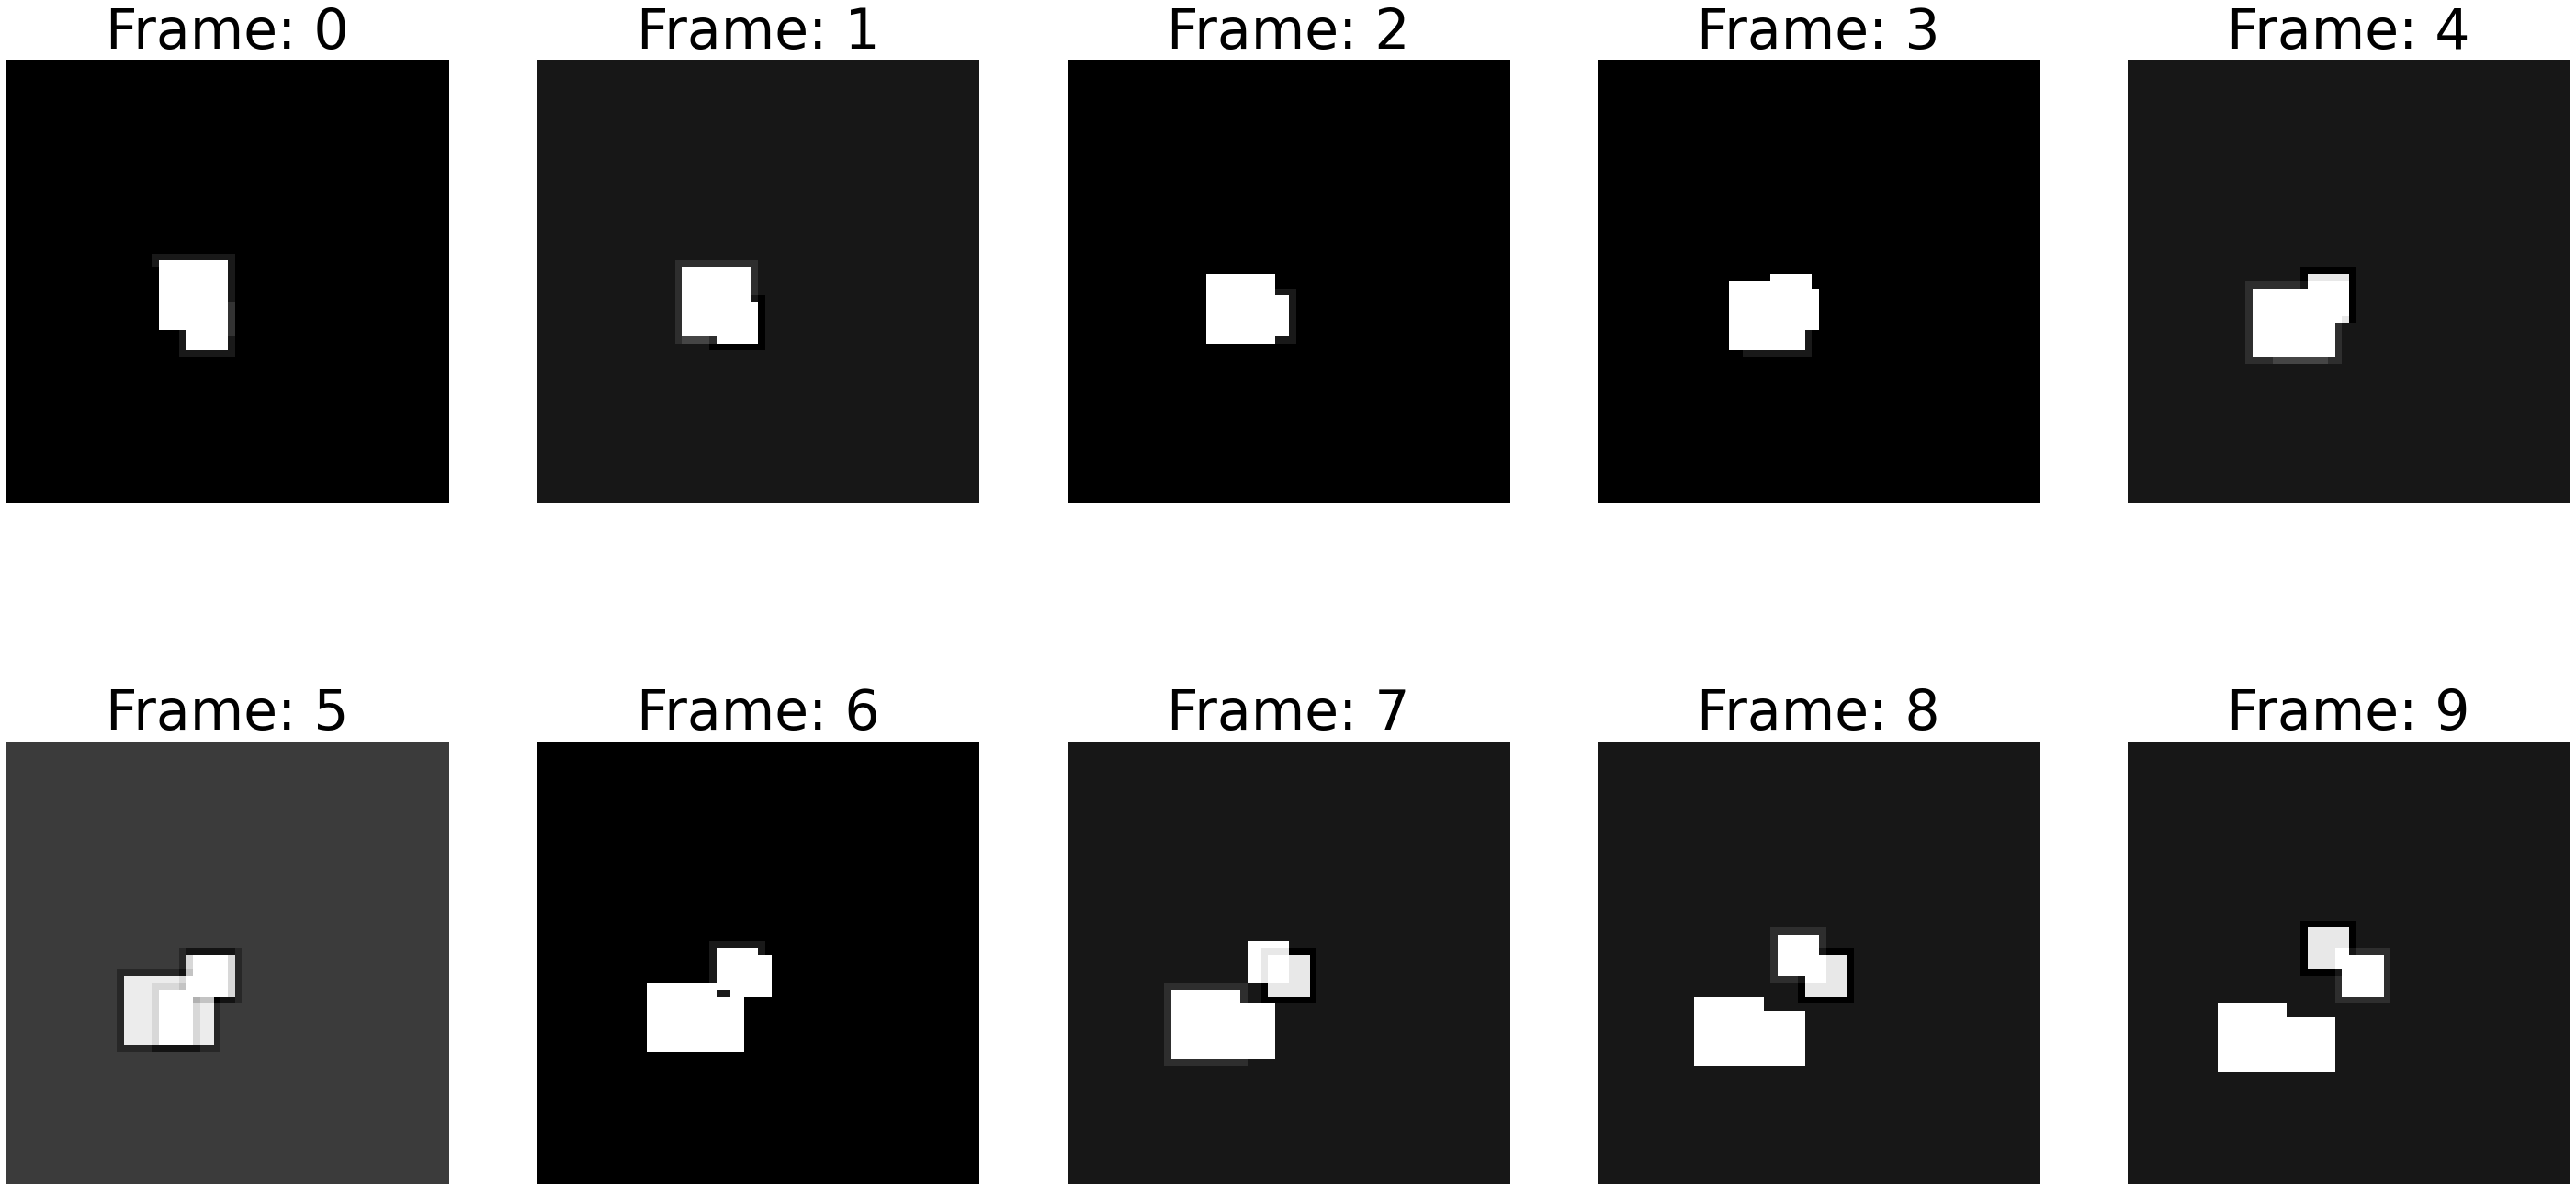

In [ ]:
#visualizing 10 frames for the first movie    THIS IS FOR THE 64X64 FRAME SIZE
fig, axes = plt.subplots(2, 5, figsize = (50, 25))
for i, ax in enumerate(axes.flat):
  ax.imshow(np.squeeze(movies[0][i]), cmap="gray")
  ax.set_title("Frame: {}".format(i), fontsize =60)
  ax.axis("off")
plt.show()

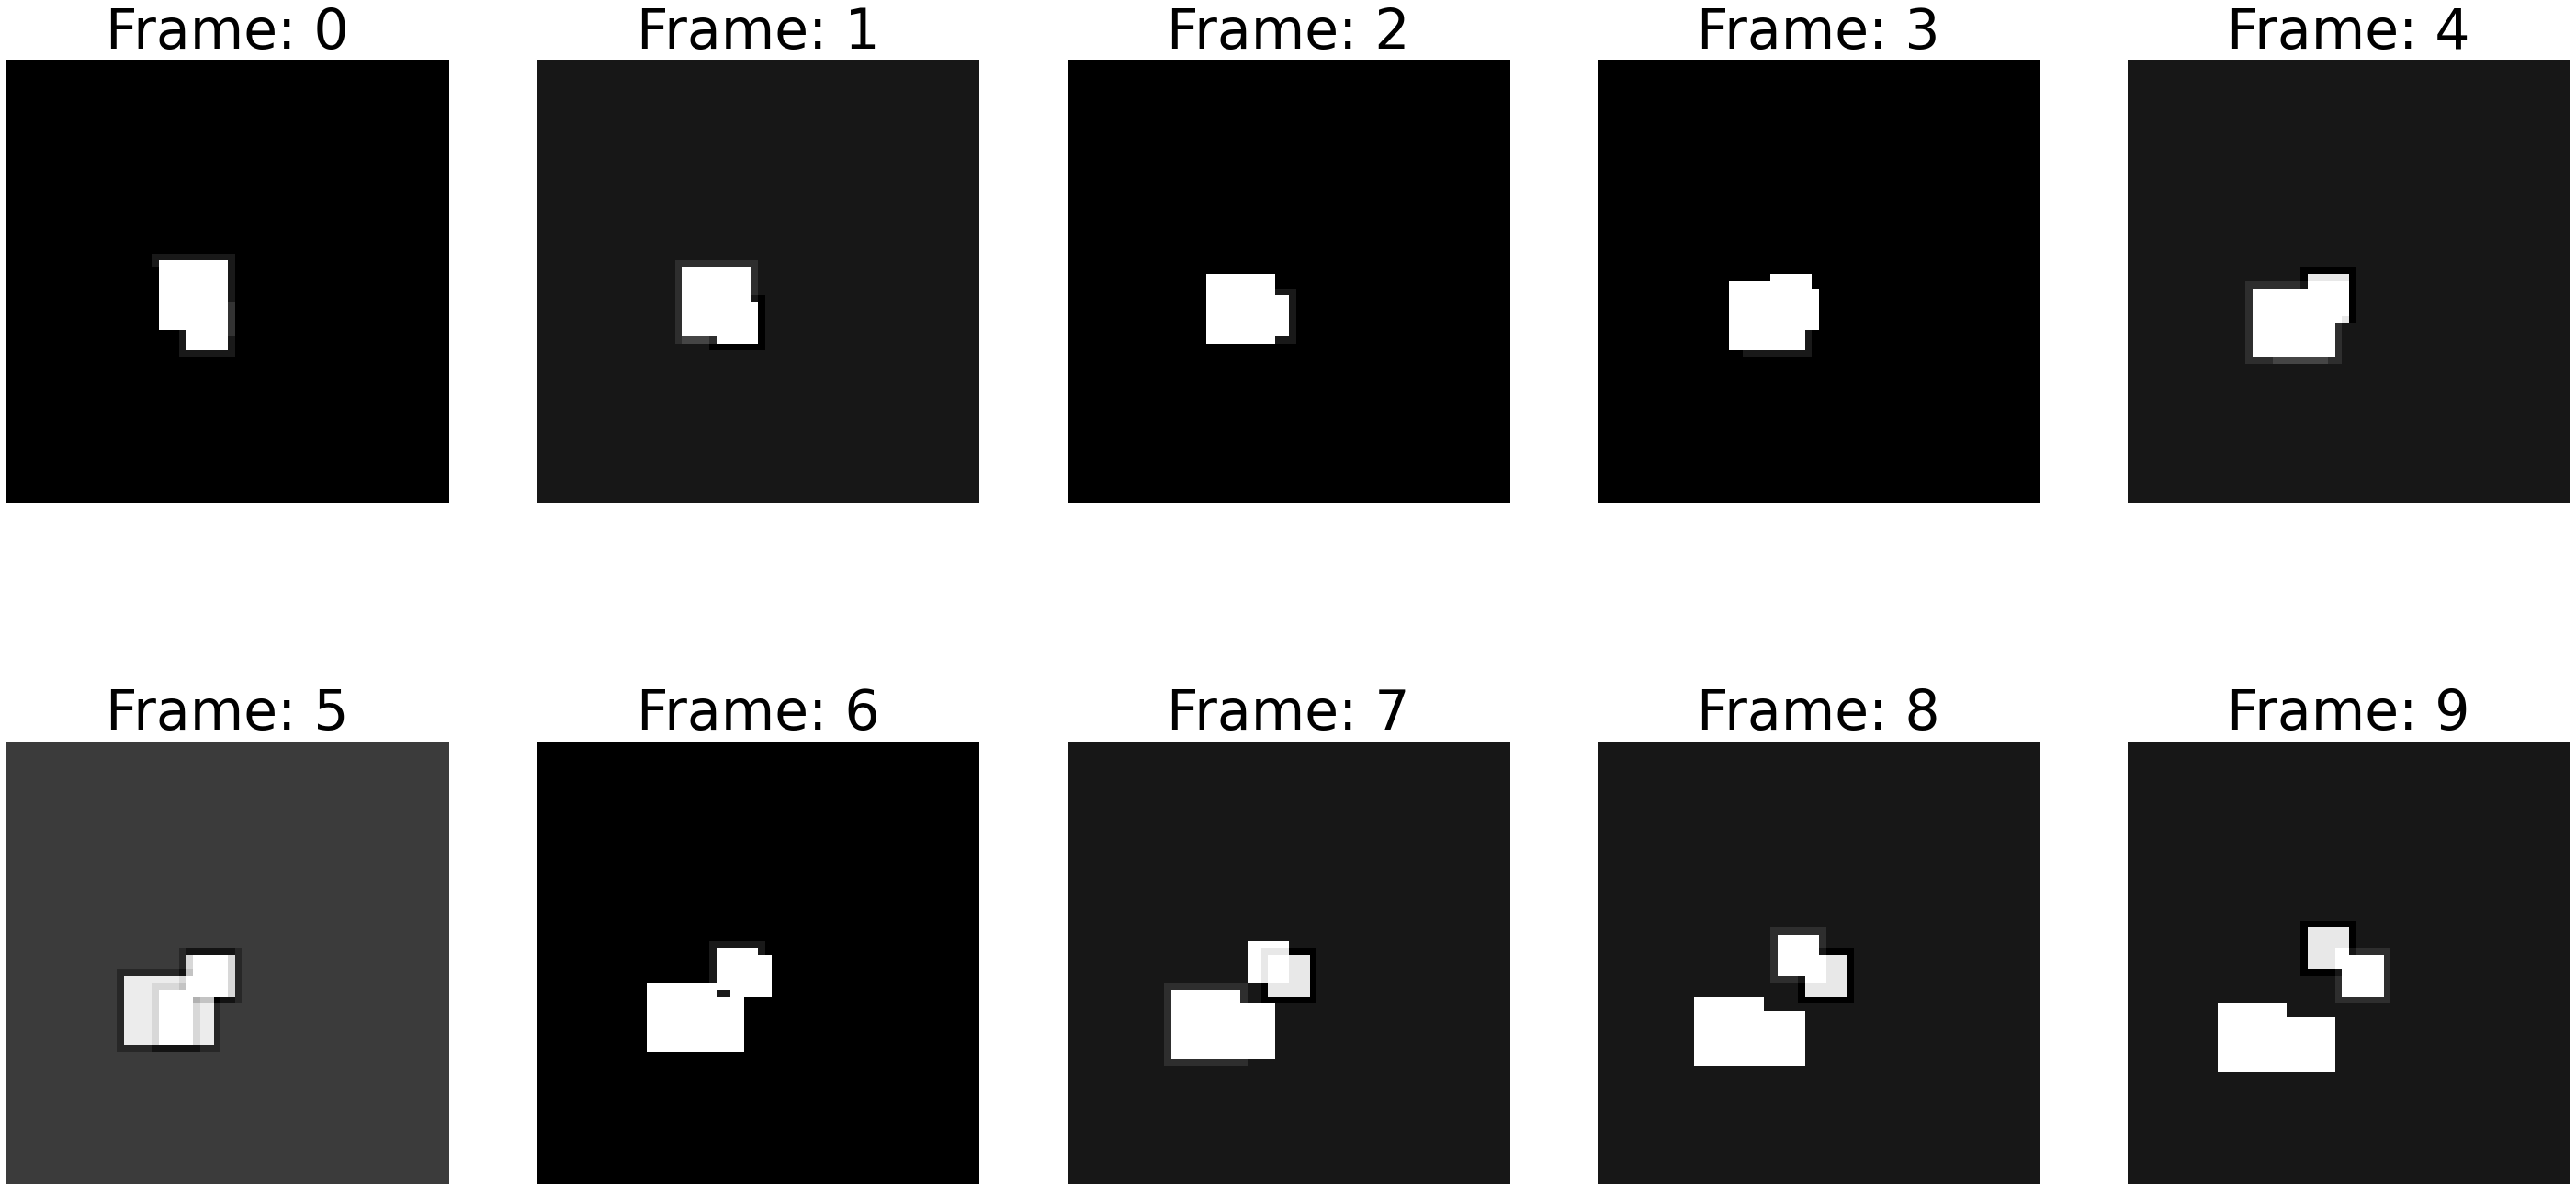

In [ ]:
#visualizing 10 frames for the first movie    THIS IS FOR THE 250X250 FRAME SIZE
fig, axes = plt.subplots(2, 5, figsize = (50, 25))
for i, ax in enumerate(axes.flat):
  ax.imshow(np.squeeze(movies[0][i]), cmap="gray")
  ax.set_title("Frame: {}".format(i), fontsize =60)
  ax.axis("off")
plt.show()

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 4096)              3355607

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)


Epoch 1/30
22/22 [==============================] - 45s 503ms/step - loss: 0.2290 - accuracy: 0.9252 - val_loss: 0.1953 - val_accuracy: 0.9328
Epoch 2/30
22/22 [==============================] - 10s 459ms/step - loss: 0.1726 - accuracy: 0.9324 - val_loss: 0.1625 - val_accuracy: 0.9330
Epoch 3/30
22/22 [==============================] - 10s 463ms/step - loss: 0.1255 - accuracy: 0.9362 - val_loss: 0.1197 - val_accuracy: 0.9383
Epoch 4/30
22/22 [==============================] - 10s 463ms/step - loss: 0.0703 - accuracy: 0.9516 - val_loss: 0.0791 - val_accuracy: 0.9496
Epoch 5/30
22/22 [==============================] - 10s 468ms/step - loss: 0.0473 - accuracy: 0.9601 - val_loss: 0.0613 - val_accuracy: 0.9543
Epoch 6/30
22/22 [==============================] - 10s 473ms/step - loss: 0.0381 - accuracy: 0.9634 - val_loss: 0.0511 - val_accuracy: 0.9586
Epoch 7/30
22/22 [==============================] - 11s 481ms/step - loss: 0.0328 - accuracy: 0.9653 - val_loss: 0.0455 - val_accuracy: 0.9605

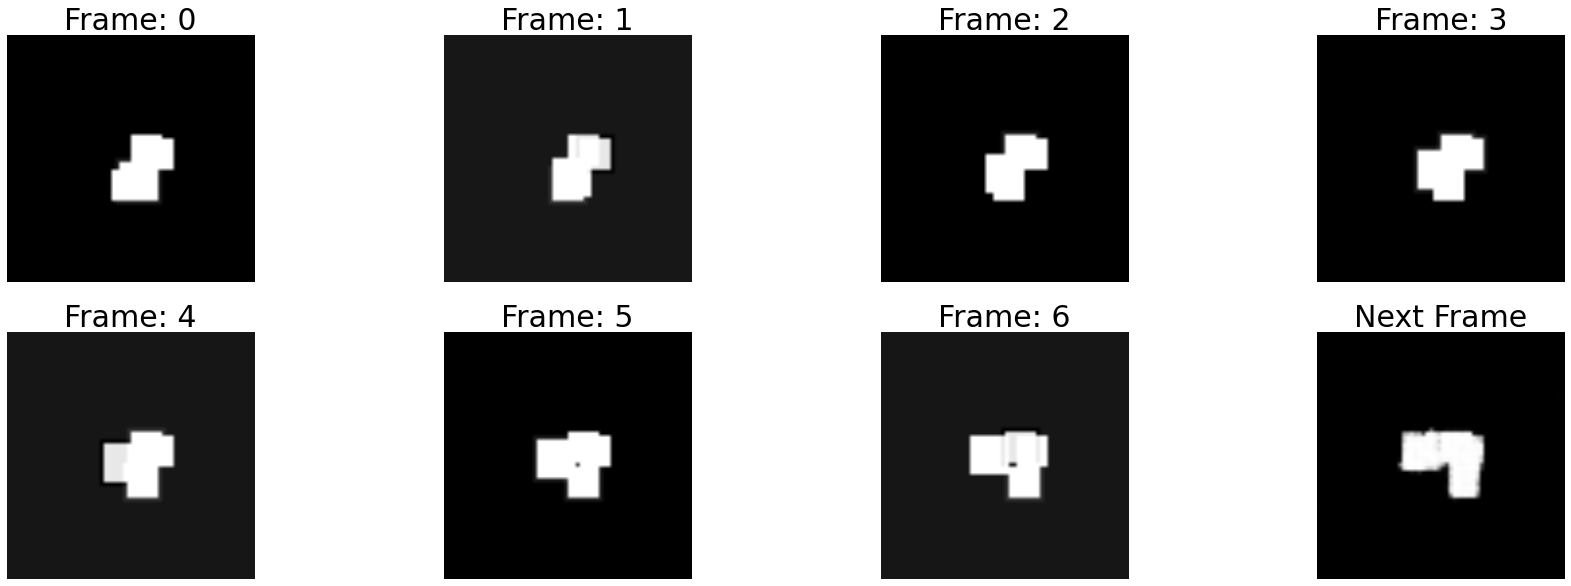

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



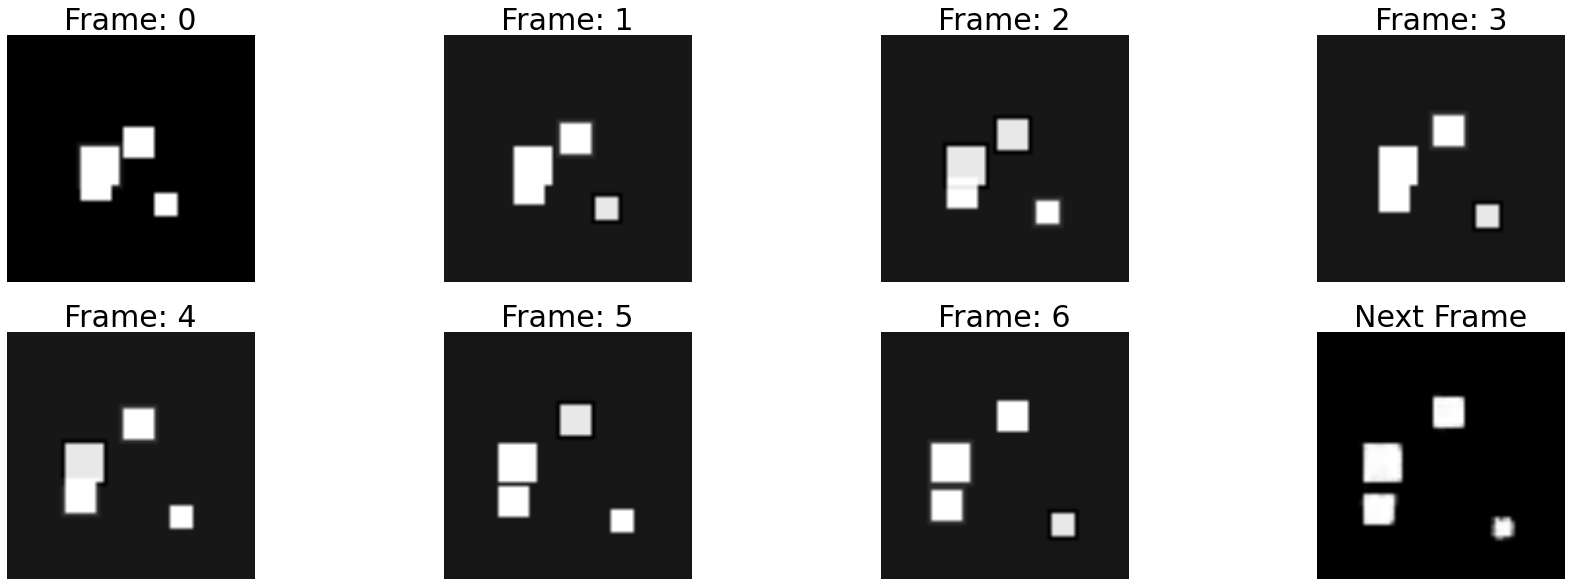

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


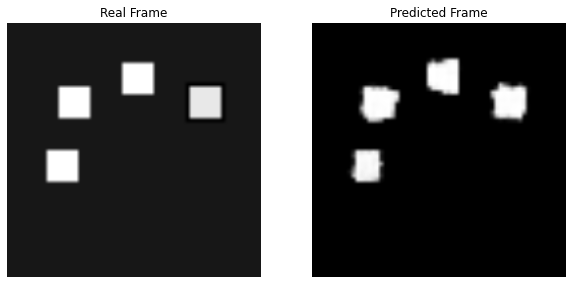

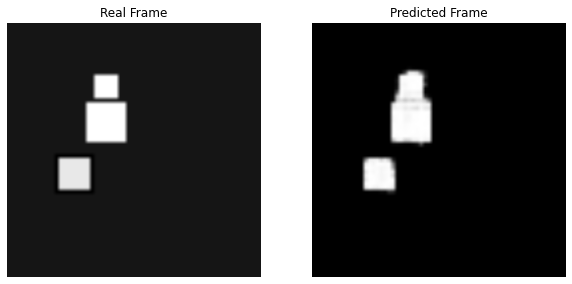

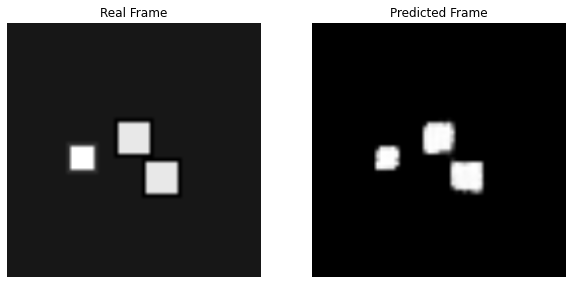

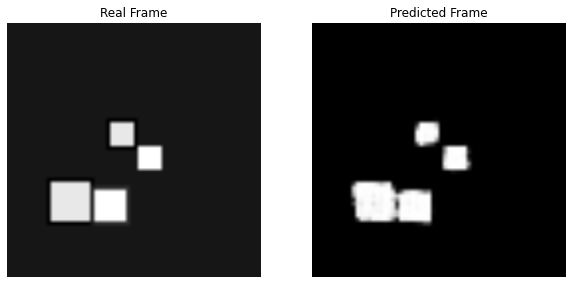

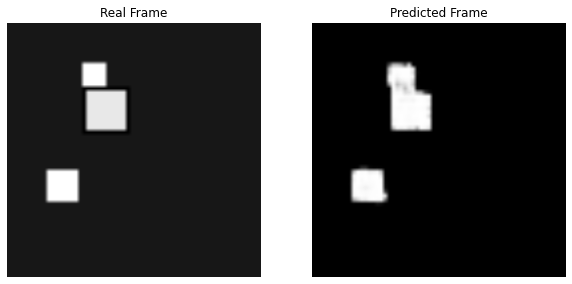

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

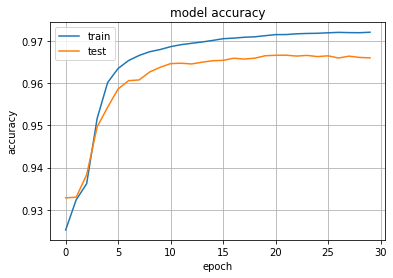

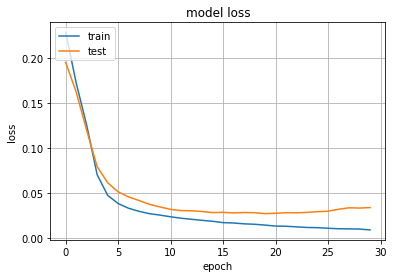

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# constructing a convolution-gru model to predict the 8th frame
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)

l = layers.GRU(64*64, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
gru =  keras.Model(encoder_input, l, name = "lstm")
gru.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_gru = keras.Model(encoder_input, d)
conv_gru.summary()
conv_gru.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 16384)          0         
_________________________________________________________________
gru (GRU)                    (None, 4096)              2516828

In [ ]:
%%time
gru_history = conv_gru.fit(x=input_sequence_merged,y=output_sequence_merged, epochs=20, batch_size=64, validation_split=0.1)

Epoch 1/20
24/24 [==============================] - 12s 446ms/step - loss: 0.2656 - accuracy: 0.8964 - val_loss: 0.1923 - val_accuracy: 0.9339
Epoch 2/20
24/24 [==============================] - 10s 405ms/step - loss: 0.1256 - accuracy: 0.9364 - val_loss: 0.1342 - val_accuracy: 0.9340
Epoch 3/20
24/24 [==============================] - 10s 416ms/step - loss: 0.0662 - accuracy: 0.9531 - val_loss: 0.1373 - val_accuracy: 0.9368
Epoch 4/20
24/24 [==============================] - 10s 414ms/step - loss: 0.0439 - accuracy: 0.9613 - val_loss: 0.1424 - val_accuracy: 0.9386
Epoch 5/20
24/24 [==============================] - 10s 404ms/step - loss: 0.0343 - accuracy: 0.9646 - val_loss: 0.1354 - val_accuracy: 0.9425
Epoch 6/20
24/24 [==============================] - 10s 397ms/step - loss: 0.0296 - accuracy: 0.9662 - val_loss: 0.1277 - val_accuracy: 0.9449
Epoch 7/20
24/24 [==============================] - 9s 390ms/step - loss: 0.0264 - accuracy: 0.9672 - val_loss: 0.1254 - val_accuracy: 0.9469


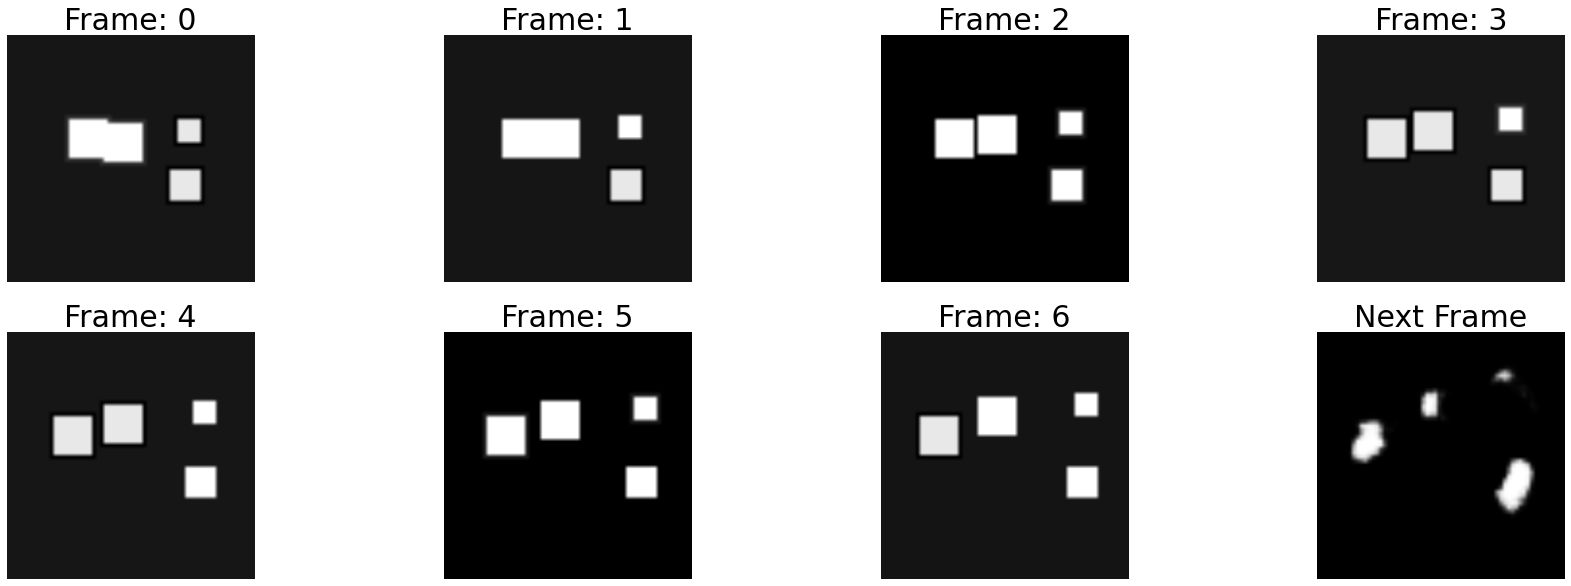

In [ ]:
# conv-gru output
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_gru.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()

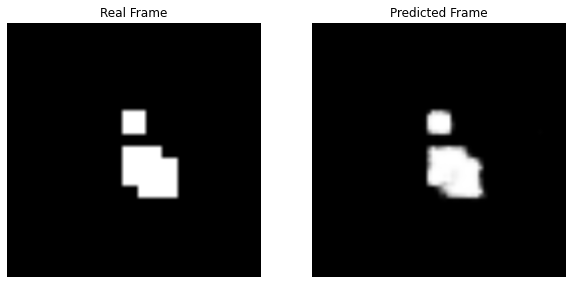

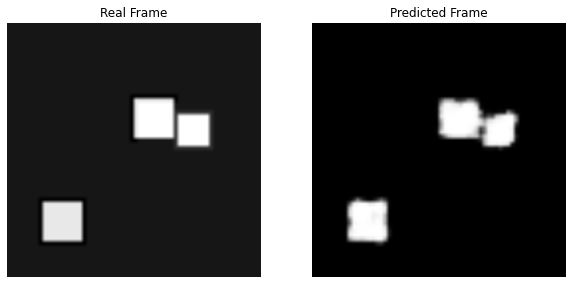

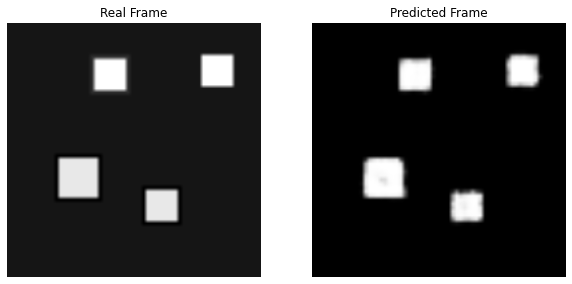

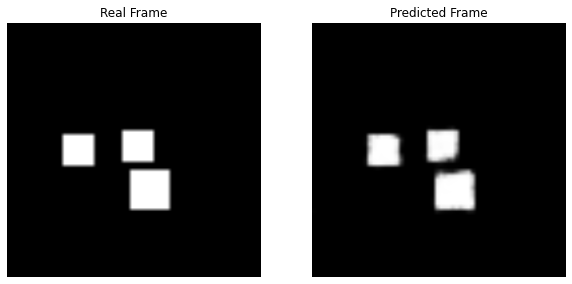

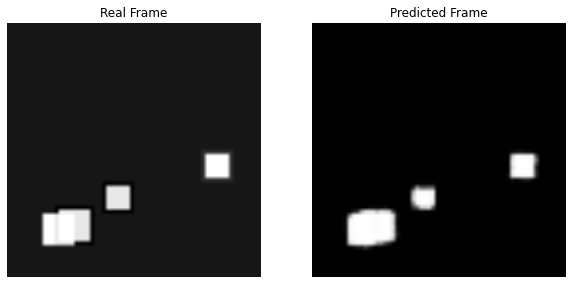

In [ ]:
#---------------------------------comparison for 5 sets
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_gru.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

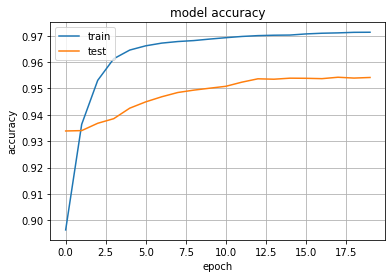

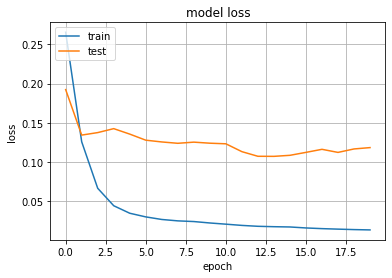

In [ ]:
# summarize history for gru-lstm
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
# constructing a convolution-rnn model to predict the 8th frame
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
encoder = keras.Model(encoder_input, x, name="encoder")
encoder.summary()

l = layers.SimpleRNN(64*64, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_rnn = keras.Model(encoder_input, d)
conv_rnn.summary()
conv_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 16384)          0         
Total params: 9,440
Trainable params: 9,440
Non-trainable params: 0
_________________________________________________________

In [ ]:
%%time
rnn_history = conv_rnn.fit(x=input_sequence_merged,y=output_sequence_merged, epochs=20, batch_size=64, validation_split=0.1)

Epoch 1/20
24/24 [==============================] - 6s 202ms/step - loss: 0.2772 - accuracy: 0.8785 - val_loss: 0.1860 - val_accuracy: 0.9339
Epoch 2/20
24/24 [==============================] - 5s 192ms/step - loss: 0.1639 - accuracy: 0.9322 - val_loss: 0.1671 - val_accuracy: 0.9337
Epoch 3/20
24/24 [==============================] - 5s 197ms/step - loss: 0.1297 - accuracy: 0.9342 - val_loss: 0.1323 - val_accuracy: 0.9369
Epoch 4/20
24/24 [==============================] - 5s 198ms/step - loss: 0.0748 - accuracy: 0.9492 - val_loss: 0.0948 - val_accuracy: 0.9448
Epoch 5/20
24/24 [==============================] - 5s 200ms/step - loss: 0.0495 - accuracy: 0.9587 - val_loss: 0.0883 - val_accuracy: 0.9489
Epoch 6/20
24/24 [==============================] - 5s 202ms/step - loss: 0.0384 - accuracy: 0.9629 - val_loss: 0.0886 - val_accuracy: 0.9499
Epoch 7/20
24/24 [==============================] - 5s 200ms/step - loss: 0.0332 - accuracy: 0.9648 - val_loss: 0.0892 - val_accuracy: 0.9503
Epoch 

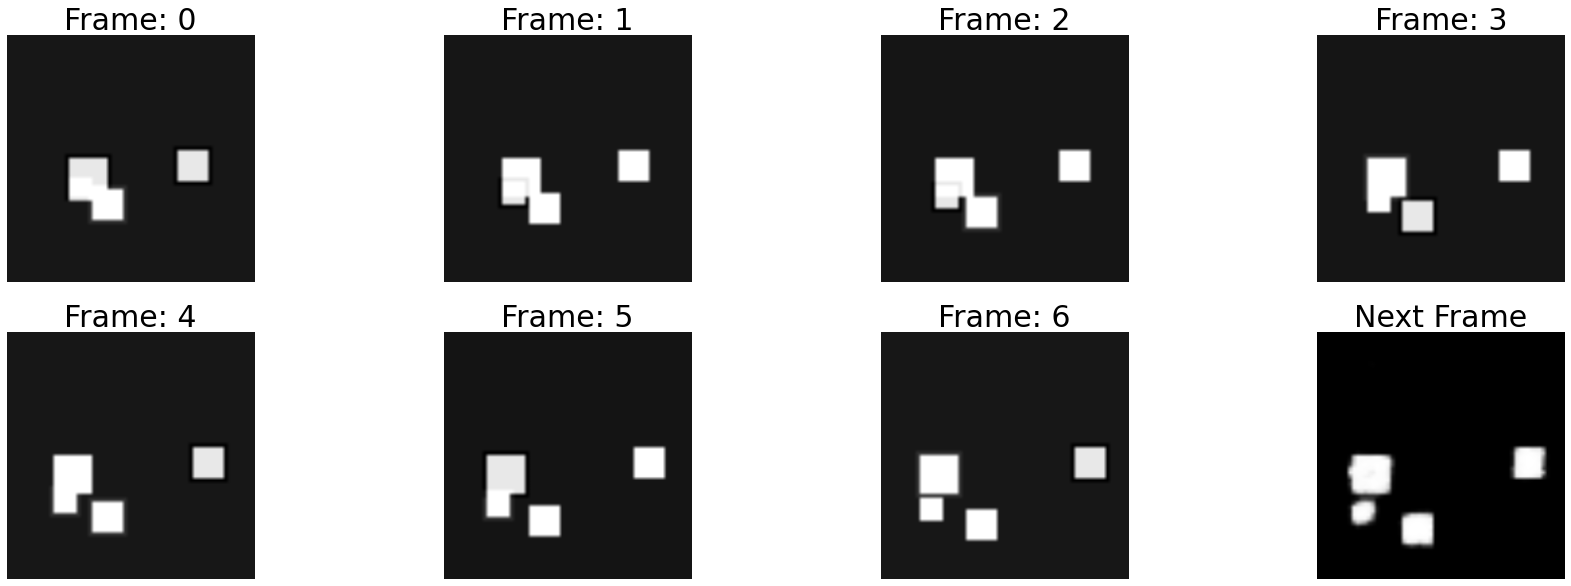

In [ ]:
# conv-rnn output
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_rnn.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()

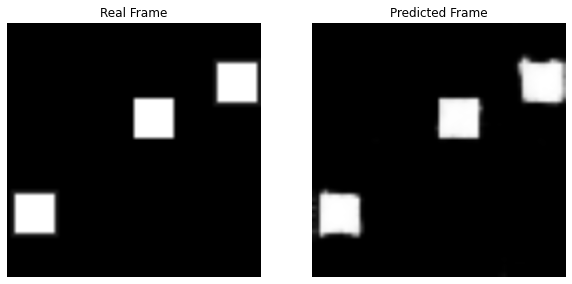

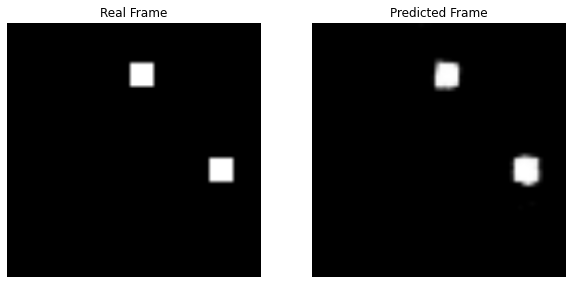

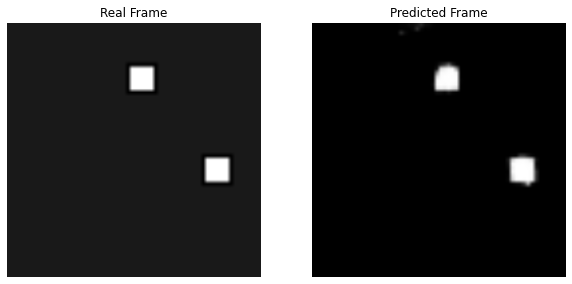

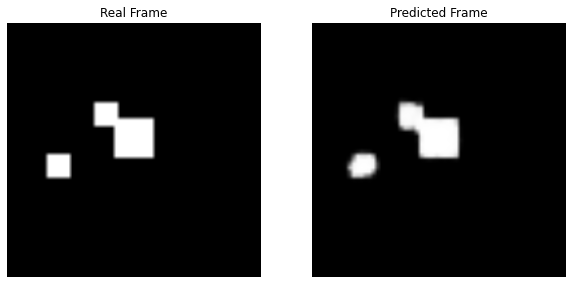

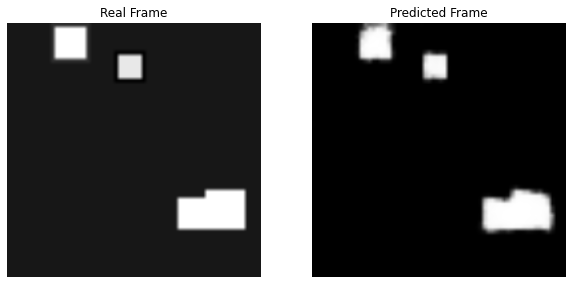

In [ ]:
#---------------------------------comparison for 5 sets
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_rnn.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

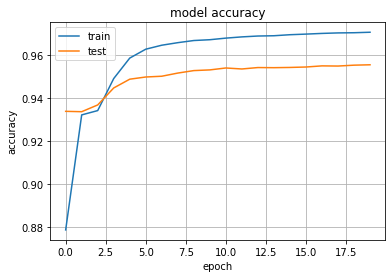

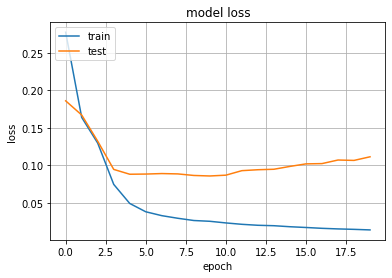

In [ ]:
# summarize history for accuracy
plt.plot(rnn_history.history['accuracy'])
plt.plot(rnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
# summarize history for loss
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()

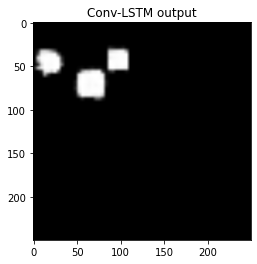

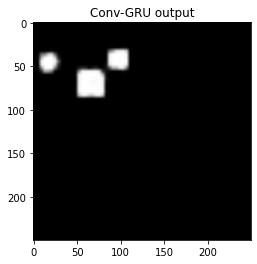

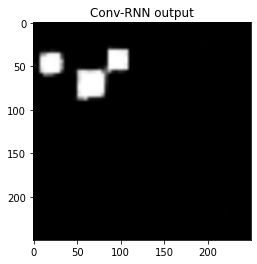

In [ ]:

index = int(random.random()*x_train.shape[0])
lstm_pred = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
plt.imshow(expandDim(np.squeeze(lstm_pred)), cmap="gray")
plt.title('Conv-LSTM output')
plt.show()
gru_pred = conv_gru.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
plt.imshow(expandDim(np.squeeze(gru_pred)), cmap="gray")
plt.title('Conv-GRU output')
plt.show()
rnn_pred = conv_rnn.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
plt.imshow(expandDim(np.squeeze(rnn_pred)), cmap="gray")
plt.title('Conv-RNN output')
plt.show()


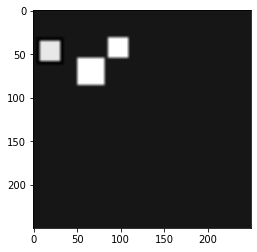

In [ ]:
plt.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
plt.show()

In [ ]:
#PHASE 2

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame with MSE
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='adam', loss='MSE', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 4096)              3355607

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)

Epoch 1/30
22/22 [==============================] - 16s 512ms/step - loss: 0.0747 - accuracy: 0.8875 - val_loss: 0.0471 - val_accuracy: 0.9333
Epoch 2/30
22/22 [==============================] - 10s 471ms/step - loss: 0.0425 - accuracy: 0.9351 - val_loss: 0.0440 - val_accuracy: 0.9333
Epoch 3/30
22/22 [==============================] - 11s 479ms/step - loss: 0.0293 - accuracy: 0.9449 - val_loss: 0.0449 - val_accuracy: 0.9435
Epoch 4/30
22/22 [==============================] - 11s 484ms/step - loss: 0.0170 - accuracy: 0.9575 - val_loss: 0.0282 - val_accuracy: 0.9465
Epoch 5/30
22/22 [==============================] - 11s 486ms/step - loss: 0.0116 - accuracy: 0.9633 - val_loss: 0.0211 - val_accuracy: 0.9540
Epoch 6/30
22/22 [==============================] - 11s 485ms/step - loss: 0.0091 - accuracy: 0.9660 - val_loss: 0.0175 - val_accuracy: 0.9567
Epoch 7/30
22/22 [==============================] - 11s 492ms/step - loss: 0.0078 - accuracy: 0.9673 - val_loss: 0.0143 - val_accuracy: 0.9590

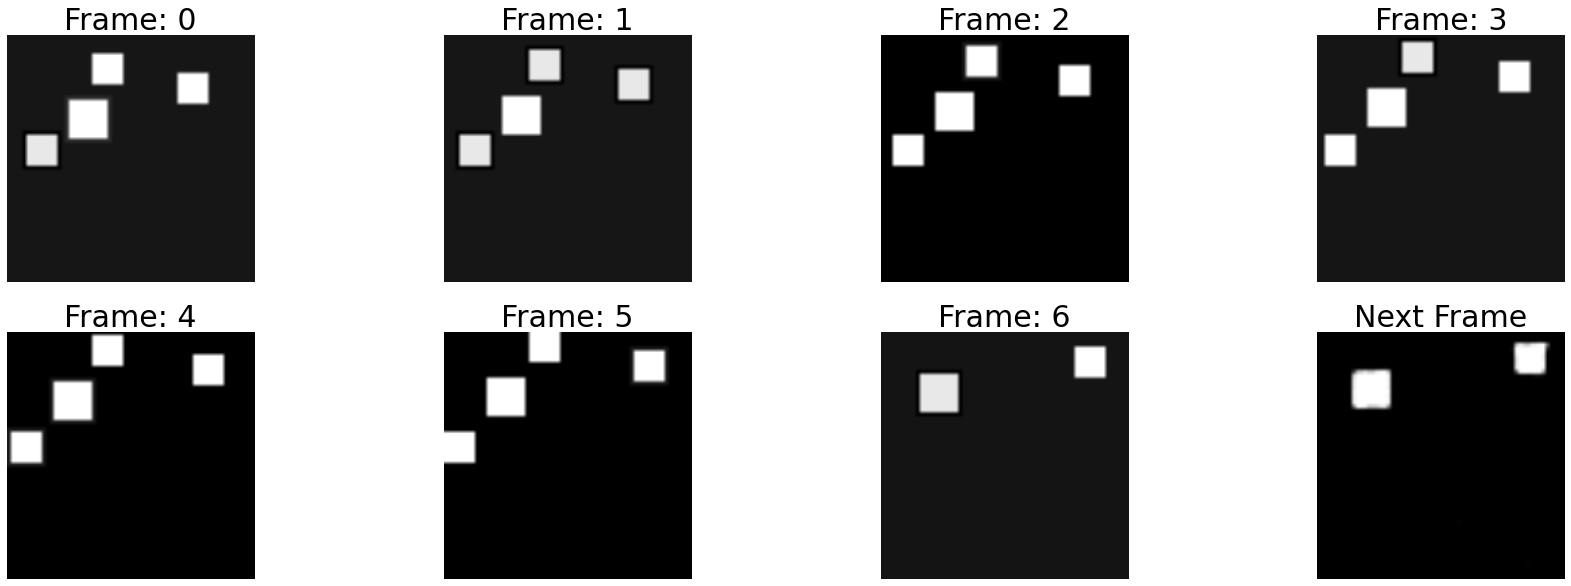

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



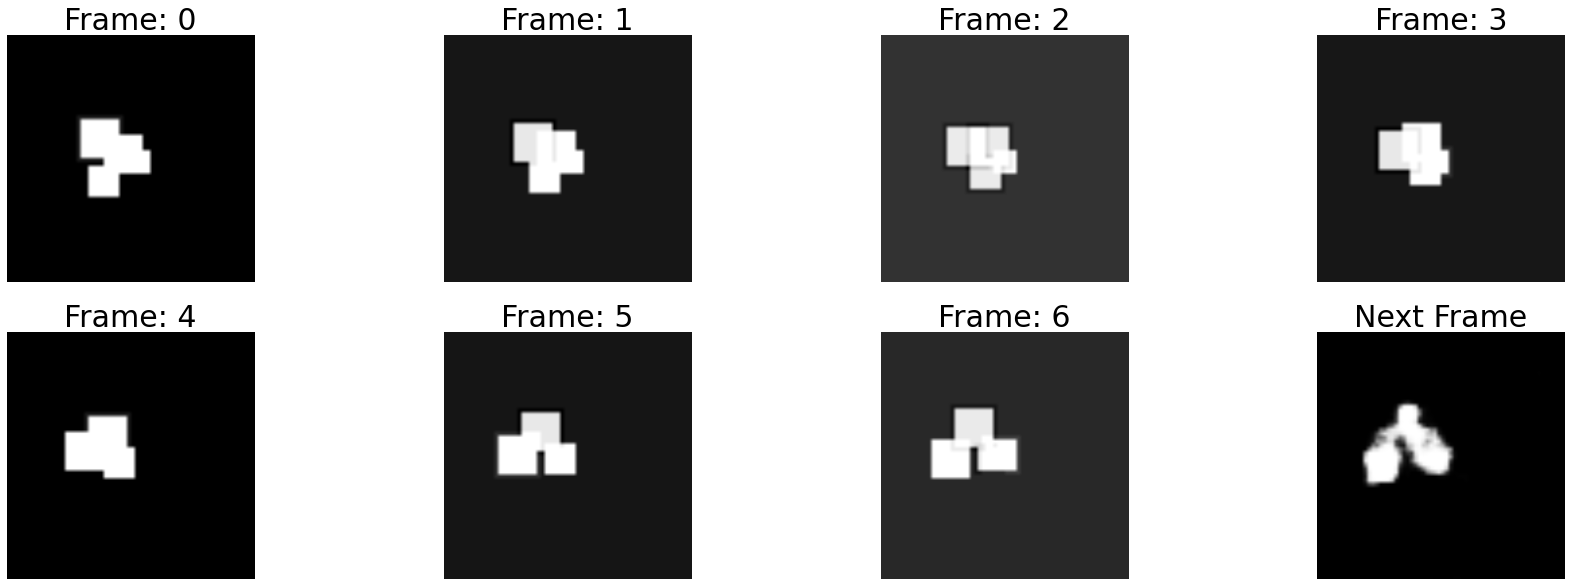

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


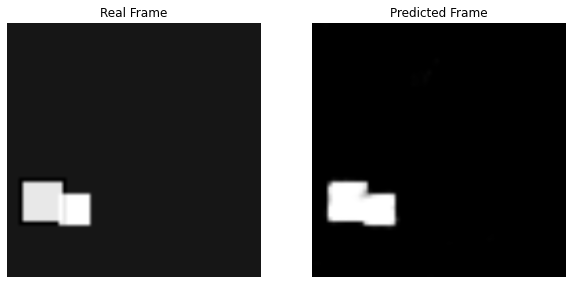

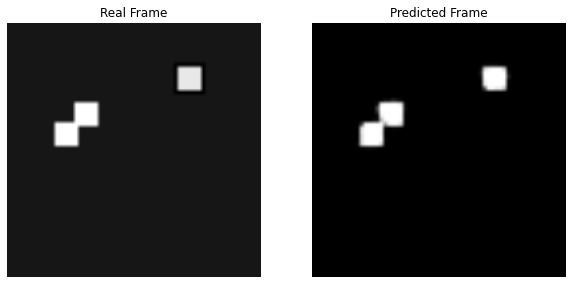

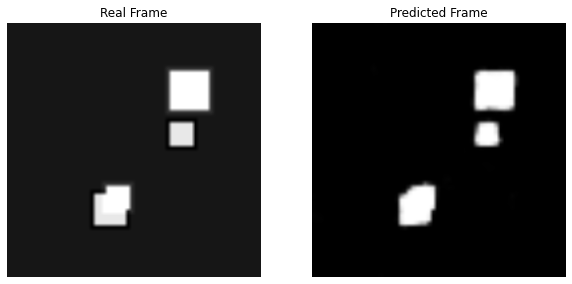

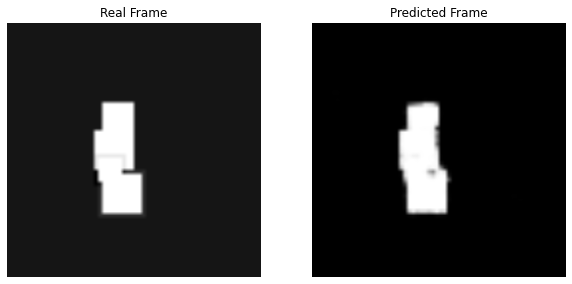

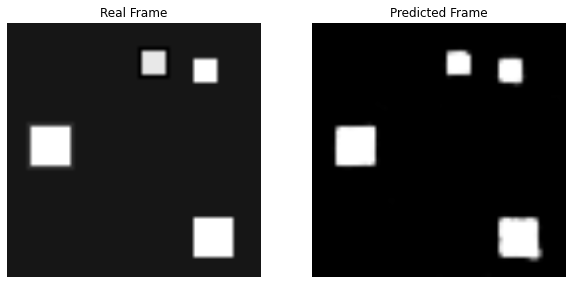

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

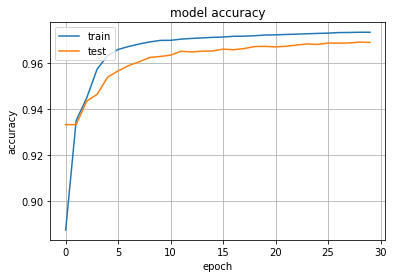

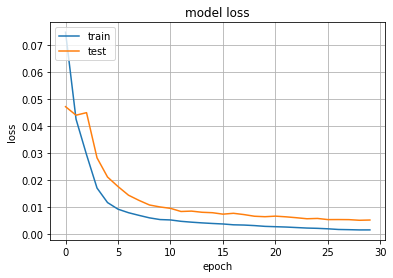

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#PHASE 3

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame with RMSProp
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 4096)              3355607

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)

Epoch 1/30
22/22 [==============================] - 19s 622ms/step - loss: 0.2264 - accuracy: 0.9184 - val_loss: 0.3111 - val_accuracy: 0.9262
Epoch 2/30
22/22 [==============================] - 13s 589ms/step - loss: 0.1514 - accuracy: 0.9306 - val_loss: 0.2386 - val_accuracy: 0.9357
Epoch 3/30
22/22 [==============================] - 13s 592ms/step - loss: 0.0777 - accuracy: 0.9464 - val_loss: 0.1341 - val_accuracy: 0.9519
Epoch 4/30
22/22 [==============================] - 13s 575ms/step - loss: 0.0507 - accuracy: 0.9576 - val_loss: 0.0934 - val_accuracy: 0.9550
Epoch 5/30
22/22 [==============================] - 12s 566ms/step - loss: 0.0417 - accuracy: 0.9609 - val_loss: 0.0682 - val_accuracy: 0.9582
Epoch 6/30
22/22 [==============================] - 12s 562ms/step - loss: 0.0363 - accuracy: 0.9631 - val_loss: 0.0572 - val_accuracy: 0.9590
Epoch 7/30
22/22 [==============================] - 12s 563ms/step - loss: 0.0311 - accuracy: 0.9649 - val_loss: 0.0505 - val_accuracy: 0.9589

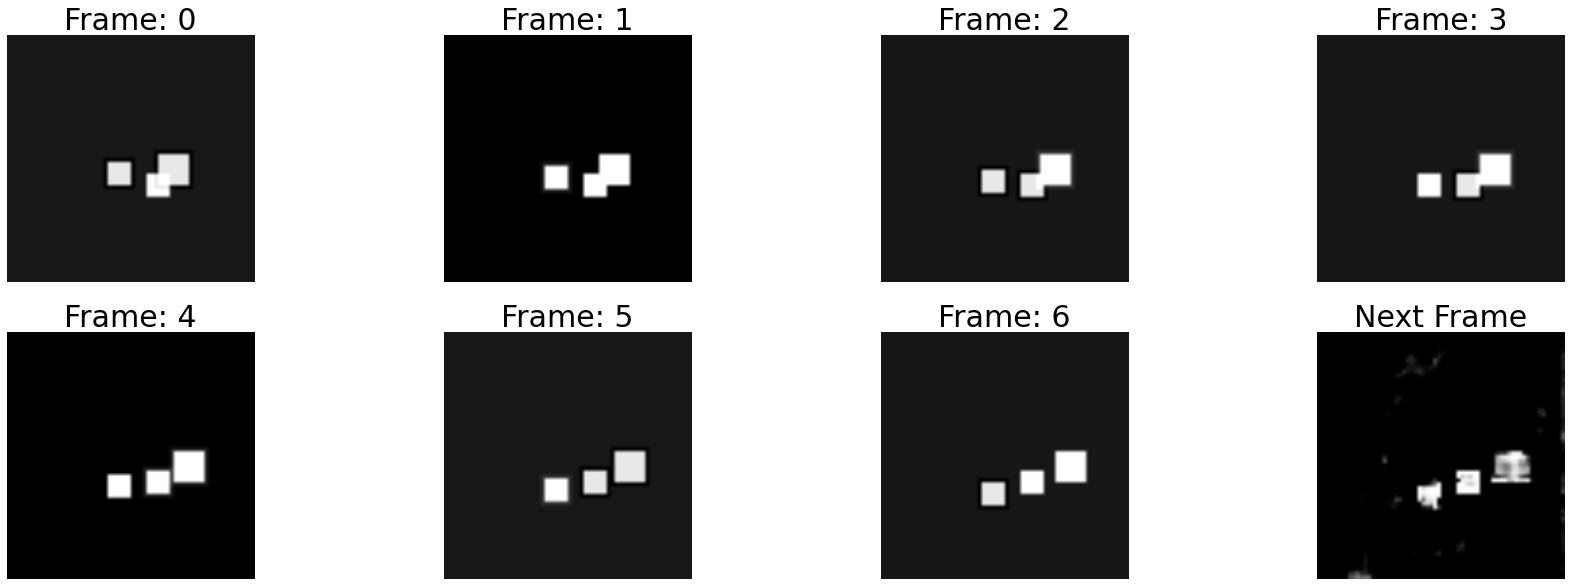

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



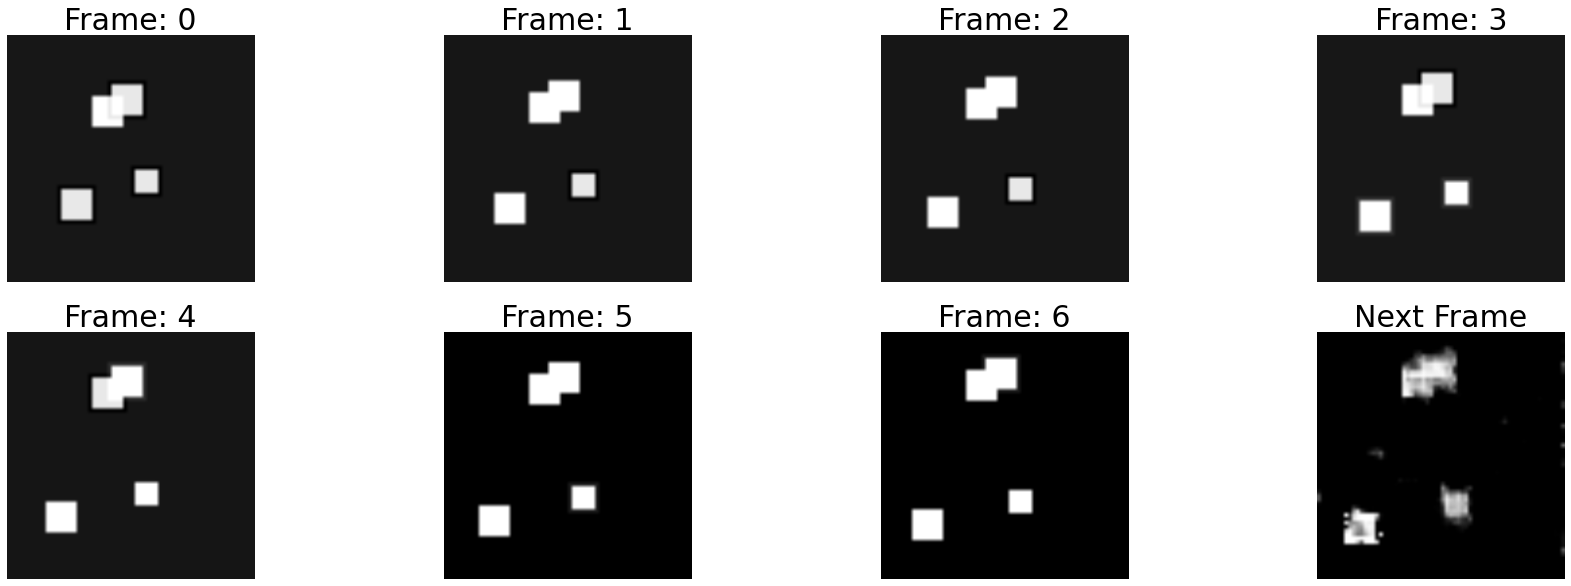

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


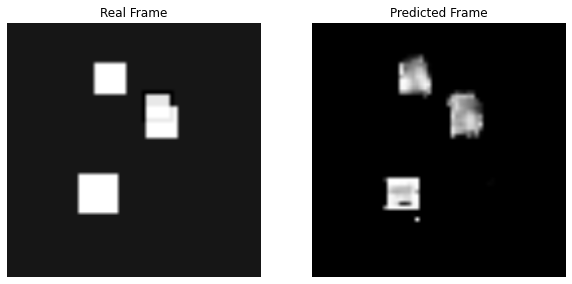

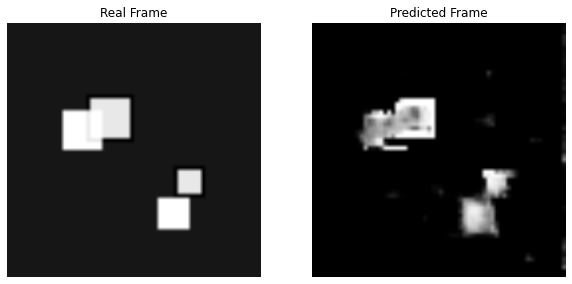

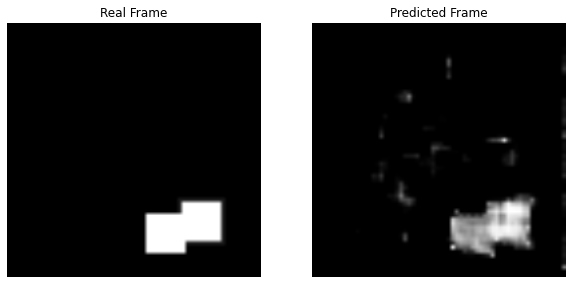

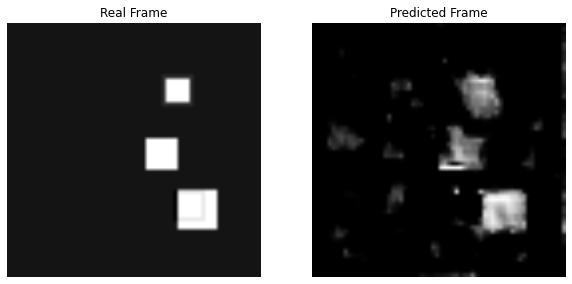

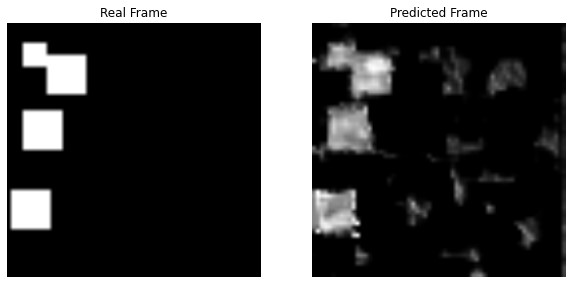

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

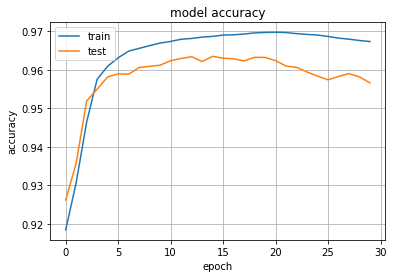

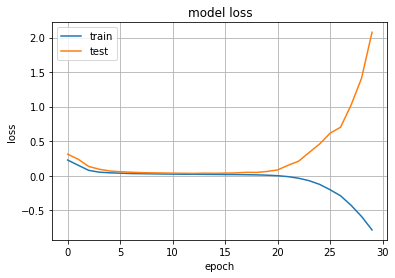

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#PHASE 4

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame with Dropout
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64))(x)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.Dropout(0.1)(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0      

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)

Epoch 1/30
22/22 [==============================] - 17s 554ms/step - loss: 0.3323 - accuracy: 0.8462 - val_loss: 0.1783 - val_accuracy: 0.9354
Epoch 2/30
22/22 [==============================] - 12s 539ms/step - loss: 0.1423 - accuracy: 0.9372 - val_loss: 0.2265 - val_accuracy: 0.9359
Epoch 3/30
22/22 [==============================] - 12s 536ms/step - loss: 0.0710 - accuracy: 0.9528 - val_loss: 0.1384 - val_accuracy: 0.9496
Epoch 4/30
22/22 [==============================] - 11s 509ms/step - loss: 0.0430 - accuracy: 0.9629 - val_loss: 0.0905 - val_accuracy: 0.9563
Epoch 5/30
22/22 [==============================] - 11s 500ms/step - loss: 0.0328 - accuracy: 0.9664 - val_loss: 0.0694 - val_accuracy: 0.9613
Epoch 6/30
22/22 [==============================] - 11s 499ms/step - loss: 0.0275 - accuracy: 0.9682 - val_loss: 0.0554 - val_accuracy: 0.9632
Epoch 7/30
22/22 [==============================] - 11s 494ms/step - loss: 0.0242 - accuracy: 0.9692 - val_loss: 0.0456 - val_accuracy: 0.9651

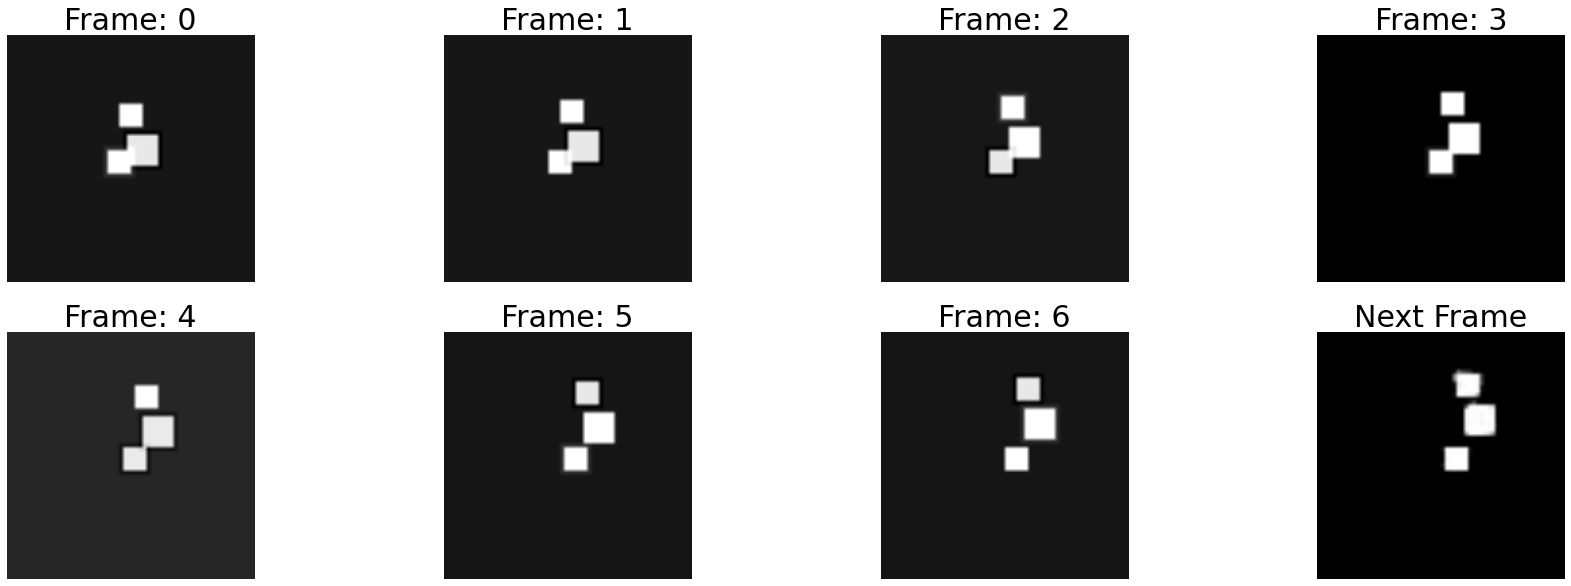

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



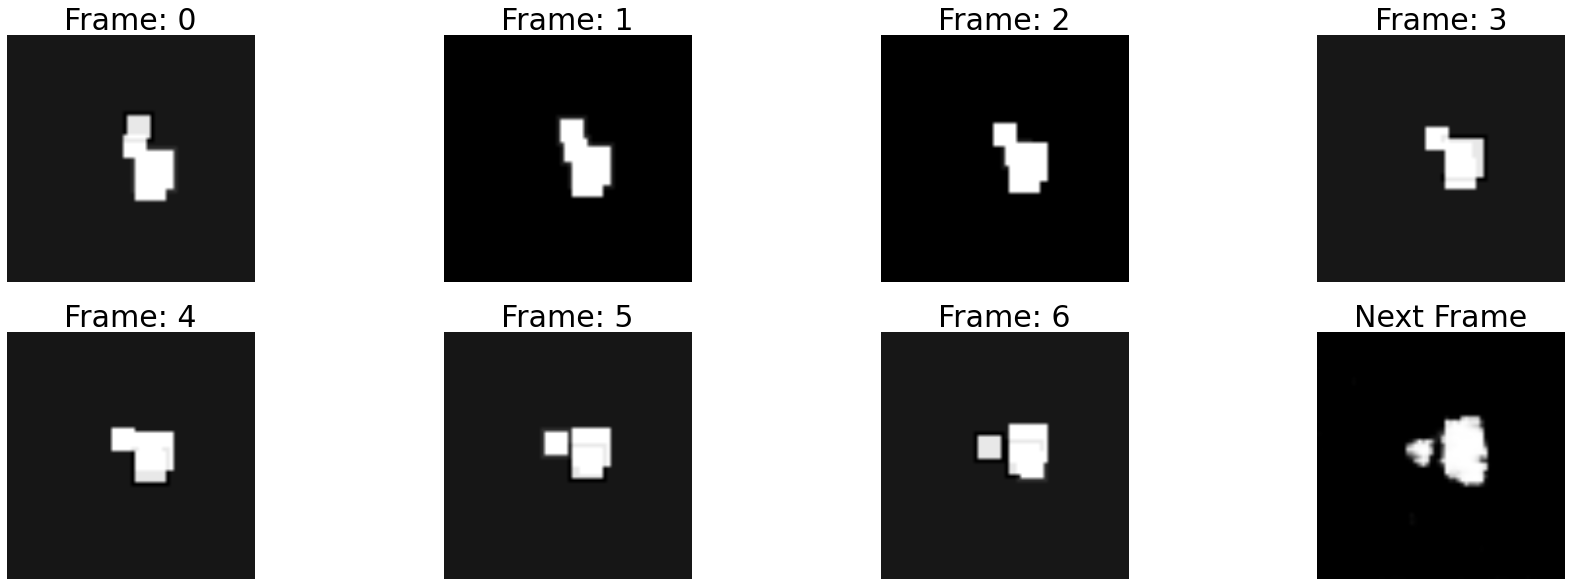

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


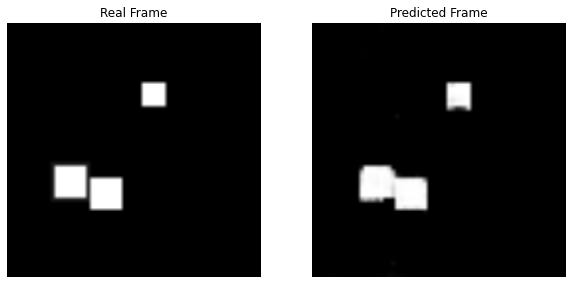

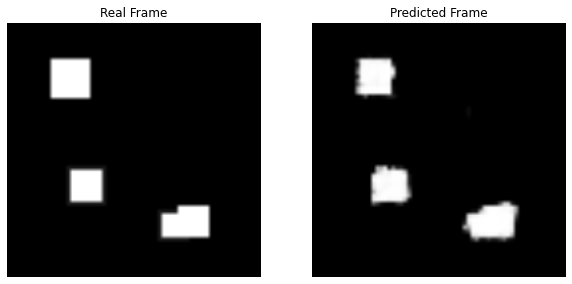

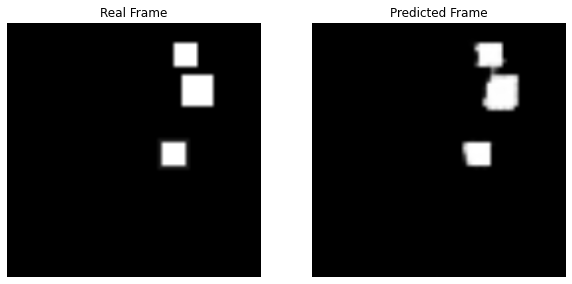

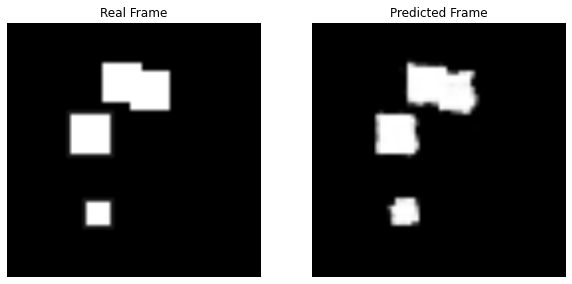

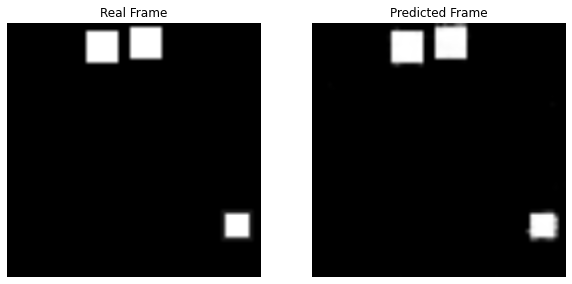

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

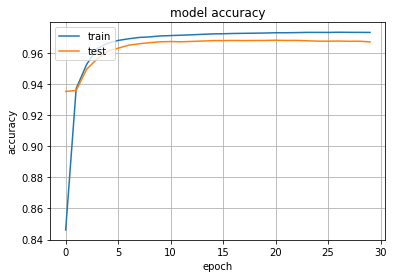

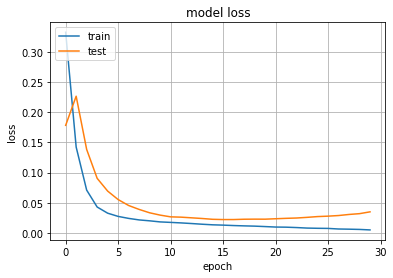

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#PHASE 5

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame with Multiple LSTM
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Dropout(0.1)(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64), return_sequences = True)(x)
l = layers.LSTM(4096)(l)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.Dropout(0.1)(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0      

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)

Epoch 1/30
22/22 [==============================] - 20s 674ms/step - loss: 0.3637 - accuracy: 0.7803 - val_loss: 0.1907 - val_accuracy: 0.9334
Epoch 2/30
22/22 [==============================] - 14s 623ms/step - loss: 0.1931 - accuracy: 0.9322 - val_loss: 0.1932 - val_accuracy: 0.9334
Epoch 3/30
22/22 [==============================] - 14s 635ms/step - loss: 0.1895 - accuracy: 0.9322 - val_loss: 0.1868 - val_accuracy: 0.9334
Epoch 4/30
22/22 [==============================] - 14s 651ms/step - loss: 0.1841 - accuracy: 0.9322 - val_loss: 0.1802 - val_accuracy: 0.9334
Epoch 5/30
22/22 [==============================] - 14s 657ms/step - loss: 0.1773 - accuracy: 0.9322 - val_loss: 0.1750 - val_accuracy: 0.9334
Epoch 6/30
22/22 [==============================] - 15s 668ms/step - loss: 0.1735 - accuracy: 0.9322 - val_loss: 0.1720 - val_accuracy: 0.9334
Epoch 7/30
22/22 [==============================] - 15s 679ms/step - loss: 0.1670 - accuracy: 0.9321 - val_loss: 0.1630 - val_accuracy: 0.9334

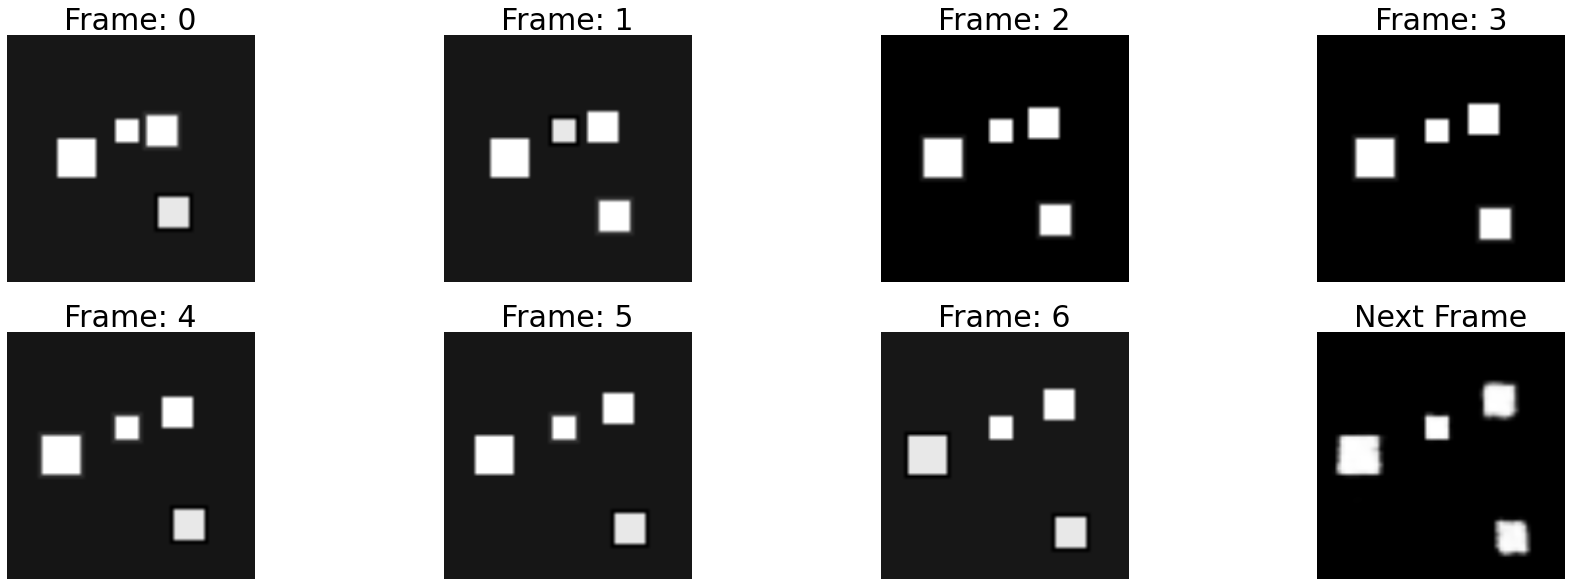

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



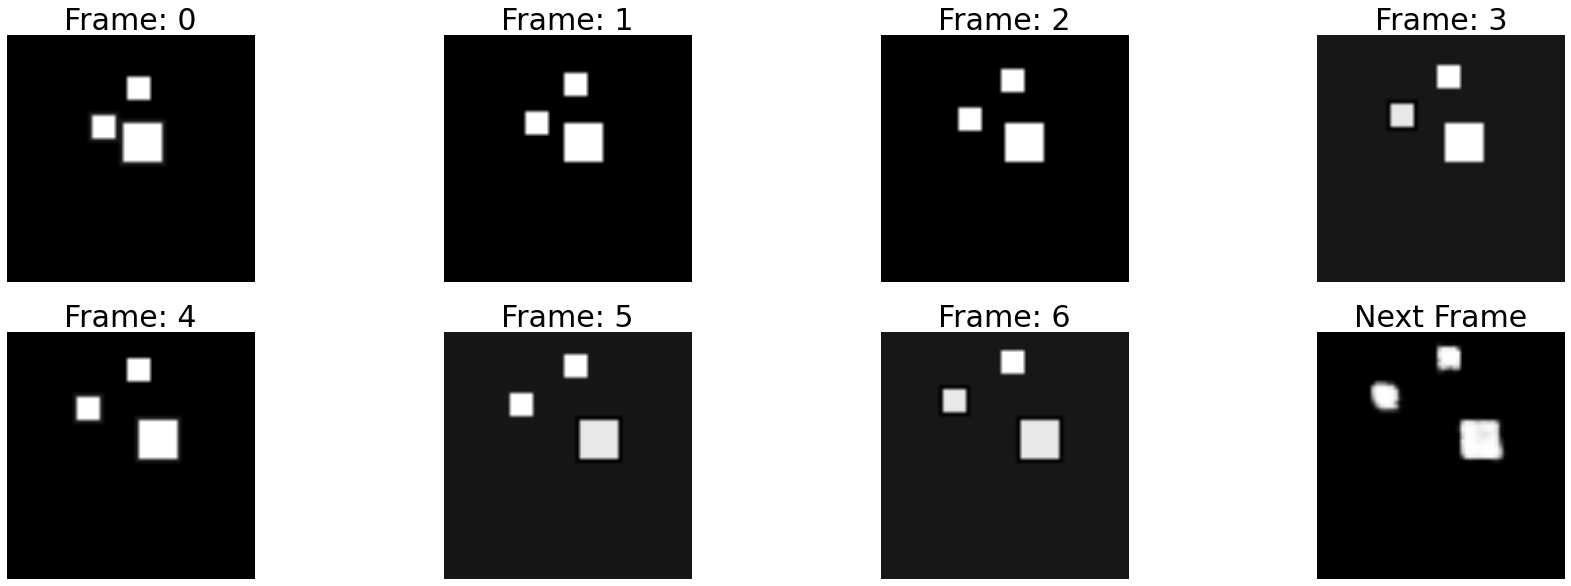

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


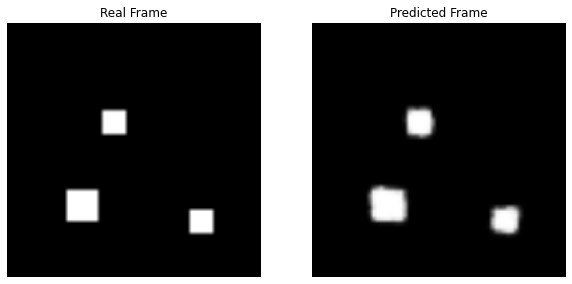

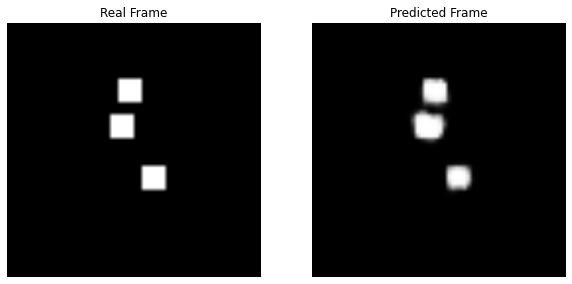

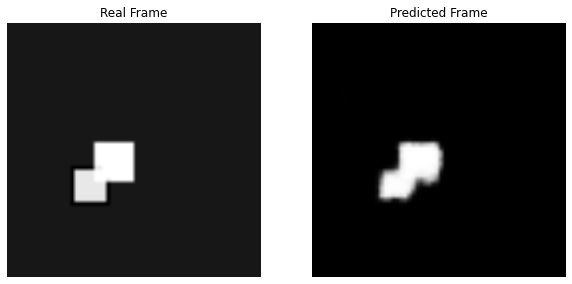

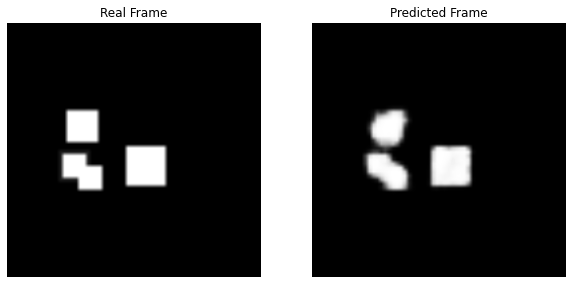

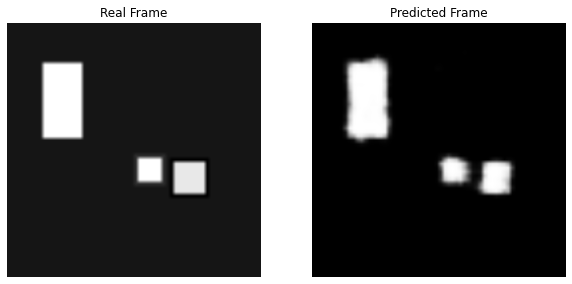

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

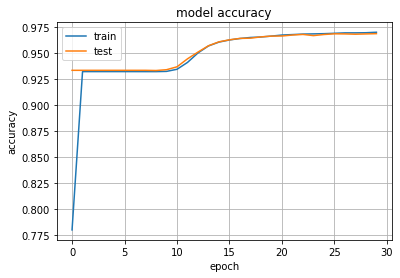

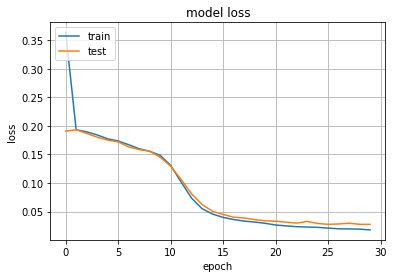

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

In [ ]:
#PHASE 6

In [ ]:
# constructing a convolution-lstm model to predict the 8th frame with Multiple LSTM
encoder_input = keras.Input(shape=(7, 64, 64, 1))
x = layers.Conv3D(16, (1, 3, 3), activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)
x = layers.Conv3D(64, (1, 3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling3D((1, 2, 2), padding='same')(x)

x = layers.Reshape((7, 16 * 16 * 64))(x)
# encoder = keras.Model(encoder_input, x, name="encoder")
# encoder.summary()

l = layers.LSTM(4096, input_shape = (7, 16 * 16 * 64), return_sequences = True)(x)
l = layers.LSTM(4096)(l)
l = layers.Dense(64 * 64)(l)
lstm =  keras.Model(encoder_input, l, name = "lstm")
lstm.summary()

d = layers.Reshape((64, 64, 1))(l)
d = layers.Convolution2DTranspose(64, (3, 3), activation = 'relu', padding = 'same')(d)
d = layers.BatchNormalization()(d)
d = layers.Convolution2DTranspose(16, (3, 3), activation = 'relu', padding = 'same')(d)
print(d.shape)

d = layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(d)
print(l.shape)
print(d.shape)
conv_lstm = keras.Model(encoder_input, d)
conv_lstm.summary()
conv_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])


Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 64, 64, 1)]    0         
_________________________________________________________________
conv3d (Conv3D)              (None, 7, 64, 64, 16)     160       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 7, 32, 32, 16)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 32, 32, 64)     9280      
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 7, 16, 16, 64)     0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 16384)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 4096)           3355607

In [ ]:
%%time
lstm_history = conv_lstm.fit(x = x_train, y = y_train, epochs = 30, batch_size = 64, validation_split = 0.1)

Epoch 1/30
22/22 [==============================] - 21s 687ms/step - loss: 0.3296 - accuracy: 0.8352 - val_loss: 0.1912 - val_accuracy: 0.9323
Epoch 2/30
22/22 [==============================] - 14s 641ms/step - loss: 0.1922 - accuracy: 0.9317 - val_loss: 0.1892 - val_accuracy: 0.9323
Epoch 3/30
22/22 [==============================] - 14s 646ms/step - loss: 0.1895 - accuracy: 0.9317 - val_loss: 0.1882 - val_accuracy: 0.9323
Epoch 4/30
22/22 [==============================] - 14s 659ms/step - loss: 0.1884 - accuracy: 0.9317 - val_loss: 0.1880 - val_accuracy: 0.9323
Epoch 5/30
22/22 [==============================] - 15s 673ms/step - loss: 0.1862 - accuracy: 0.9317 - val_loss: 0.1834 - val_accuracy: 0.9323
Epoch 6/30
22/22 [==============================] - 15s 680ms/step - loss: 0.1825 - accuracy: 0.9317 - val_loss: 0.1780 - val_accuracy: 0.9323
Epoch 7/30
22/22 [==============================] - 15s 676ms/step - loss: 0.1788 - accuracy: 0.9317 - val_loss: 0.1764 - val_accuracy: 0.9323

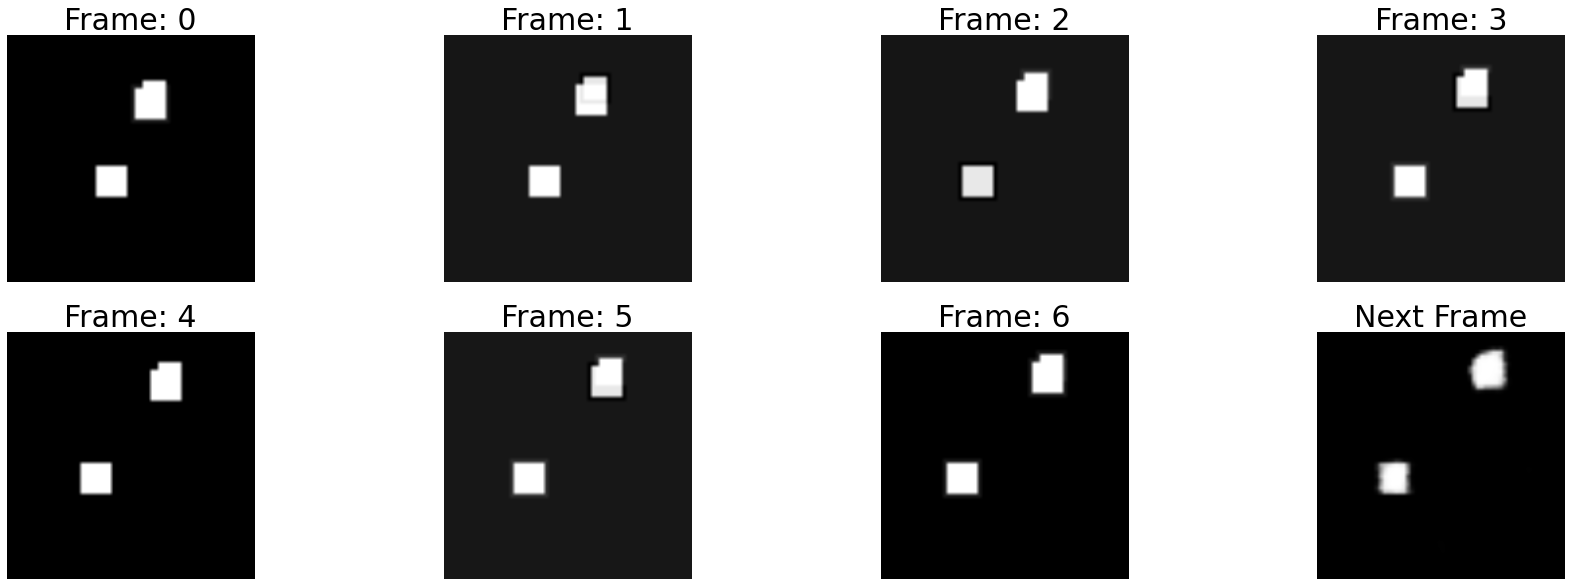

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()



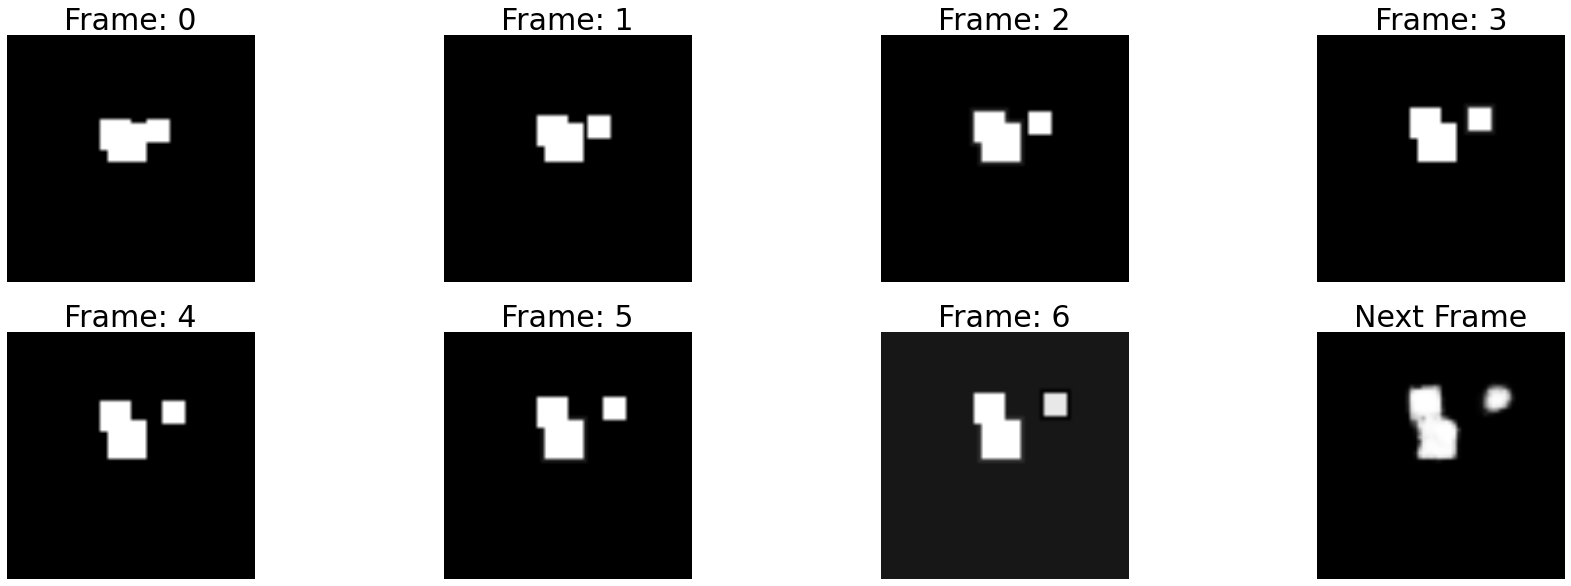

In [ ]:
index = int(random.random()*input_sequence_merged.shape[0])

nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
# nf = threshold(nf)

fig, axes = plt.subplots(2, 4, figsize = (30, 10))
for i, ax in enumerate(axes.flat):
  if i<7:
    ax.imshow(expandDim(np.squeeze(input_sequence_merged[index,i])), cmap="gray")
    ax.set_title("Frame: {}".format(i), fontsize =30)
    ax.axis("off")
  elif i==7:
    ax.imshow(expandDim(np.squeeze(nf)), cmap="gray")
    ax.set_title("Next Frame", fontsize =30)
    ax.axis("off")
plt.show()


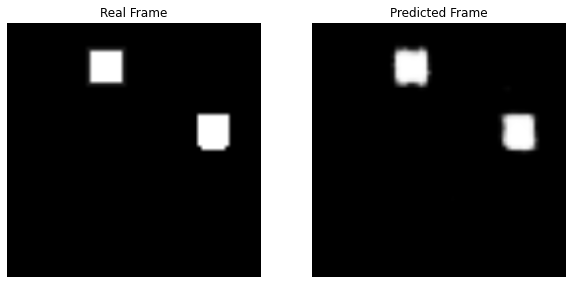

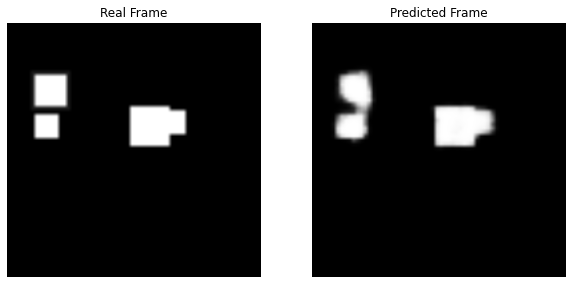

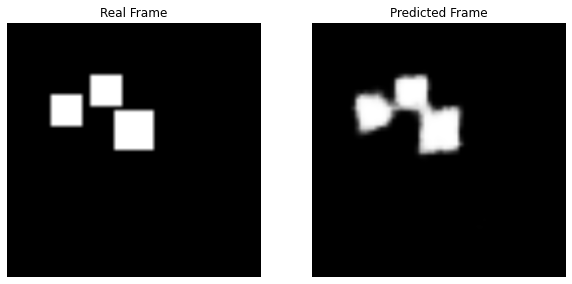

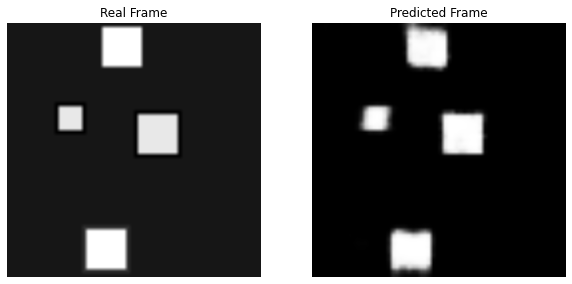

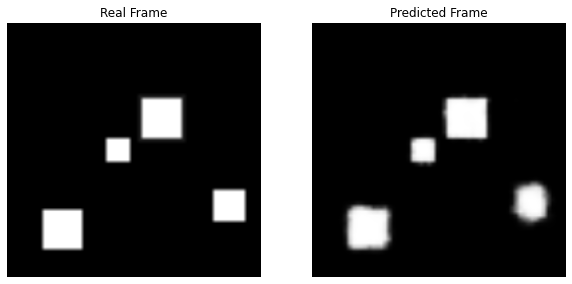

In [ ]:
#---------------------------------comparison
print()
for i in range(5):
  fig_, axes_ = plt.subplots(1, 2, figsize = (10, 5))
  index = int(random.random()*input_sequence_merged.shape[0])
  nf = conv_lstm.predict(input_sequence_merged[index].reshape(-1,7,64,64,1)).reshape(64,64,1)
  for i, ax in enumerate(axes_.flat):
    if i==0:
      ax.imshow(expandDim(np.squeeze(output_sequence_merged[index])), cmap="gray")
      ax.set_title("Real Frame")
      ax.axis("off")
    else:
      plt.imshow(expandDim(np.squeeze(nf)), cmap="gray")
      ax.set_title("Predicted Frame")  
      ax.axis("off")

plt.show()

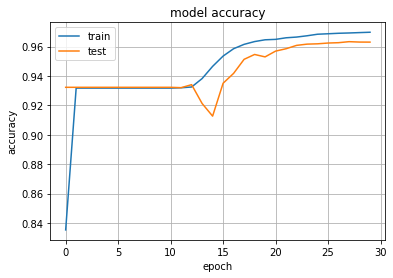

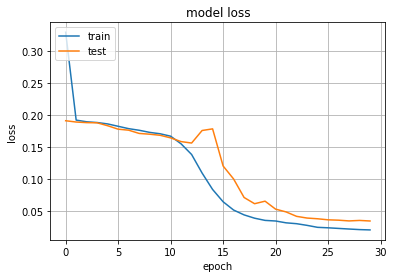

In [ ]:
# summarize history for conv-lstm
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()

plt.show()
# summarize history for loss
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()